In [1]:
%load_ext autoreload
%autoreload 2

# Анализ характеристик тандемной сети с помощью аппроксимации выходных потоков

Исследуем различные методы расчета **межконцевых задержек** и **вероятностей потери** пакетов в тандемных сетях с узлами MAP/PH/1/N. 

В этом ноутбуке мы изучим три способа расчета характеристик тандемной сети с узлами MAP/PH/1/N:

- точный расчет;
- расчет с аппроксимацией потоков;
- расчет методом Монте-Карло.


Проведем два эксперимента:

1) Проверим точность приближенных методов сравнением с точным решением.
2) Сравним точность и время расчета имитационной модели и метода аппроксимации выходных потоков на сетях большого размера.

В первом эксперименте нам придется использовать PH и MAP маленьких порядокв, небольшую емкость очереди и небольшое число станций. 
Это связано с тем, что размерность задачи растет экспоненциально с ростом размера сети, а именно как $O(W(VM)^N)$, где $W$ - порядок
MAP-потока, $V$ - порядок PH-распределений, $M$ - емкость очереди, а $N$ - число станций в сети. Для этого эксперимента мы будем
строить данные двумя способами: 

- произвольные MAP-ы, PH-распределения и длины очередей, но с не одной, двумя или тремя станциями в сети
- простейшие MAP-потоки и PH-распределения (то есть экспоненты) и малые длины очередей (до двух), но с большим числом станций в сети

Для второго эксперимента такого явного ограничения нет, хотя из-за того, что в итерационном расчете с аппроксимациями все равно
приходится строить выходящий поток, все равно будем ограничивать размеры MAP и PH.

## Подготовка ноутбука и загрузка данных

Сначала импортируем и настроим нужные нам библиотеки, а также определим функции для сохранения и загрузки данных.

In [13]:
from dataclasses import dataclass
import os
from itertools import product
from time import perf_counter
from typing import Optional
import multiprocessing

# Библиотеки для работы с данными
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from tabulate import tabulate
tqdm.pandas()  # Делаем доступными функции типа df.progress_apply()

import pyqumo
import pyqumo.algorithms
from pyqumo.utils.plots import get_color
from pyqumo.utils.text import highlight as hl, fmt_err, TextColor
from pyqumo import rel_err, MarkovArrival, PhaseType, Erlang, HyperExponential, Exponential
from pyqumo.algorithms.networks.mapph1n_tandem import solve_iterative, SolveResults

# Библиотеки для рисования графиков
import matplotlib
from matplotlib import pyplot as plt, cm
from matplotlib.lines import Line2D
import seaborn as sns

Настроим рисование графиков.

In [4]:
%matplotlib inline
CMAP_NAME = 'Dark2'
CMAP = cm.get_cmap(CMAP_NAME)
LIGHT_CMAP = cm.get_cmap("Pastel2")

Для удобства форматирования определим функции для вывода цветных строчек.

In [5]:
def fmt_header(s):
    return hl(s, TextColor.OKBLUE)
    
def fmt_delim(s):
    return hl(s, TextColor.OKCYAN)

def fmt_float(x):
    return f'{x:.4f}'

def fmt_yes_no(x, yes_is_good: bool = True):
    color = TextColor.OKGREEN if x and yes_is_good else TextColor.FAIL
    return hl('yes' if x else 'no', color, TextColor.BOLD)

### Функции для сохранения и загрузки данных

В датафреймах, с которыми мы будем работать, будут колонки, в которых содержатся MAP-потоки и PH-распределения. Их неудобно сериализовывать
в чистом виде, поэтому при сохранении в файл мы будем брать только матрицы и записывать их в новые колонки, а при загрузке - строить колонки
для MAP-потока (`"arrival"`) и PH-распределения (`"service"`), и удалять колонки с матрицами.

In [6]:
# Сначала определим вспомогательную функцию, которая разбирает строку
# в массив numpy.ndarray
def parse_numpy_array(s: str, n_dims: int = 2) -> np.ndarray:
    """
    Разбирает двумерный массив из того формата, в котором Pandas
    сохраняет ячейку с ndarray, то есть '[[1 2]\n [3 4]]'
    """
    s = s.replace('\n', '').replace('[', '').replace(']', '')
    a = np.fromstring(s, sep=' ')  # вектор, содержащий N^2 элементов
    n = int(len(a)**(1/n_dims))
    return a.reshape((n,)*n_dims)


def load_data(filename):
    """Загрузить данные из файла `filename`.
    """
    converters = {
        'arrival_d0': parse_numpy_array,
        'arrival_d1': parse_numpy_array,
        'service_s': parse_numpy_array,
        'service_p': (lambda s: parse_numpy_array(s, n_dims=1))        
    }    
    create_map = lambda row: MarkovArrival(row.arrival_d0, row.arrival_d1, tol=.01)
    create_ph = lambda row: PhaseType(row.service_s, row.service_p, tol=.01)
    
    df = pd.read_csv(filename, converters=converters)
    df['arrival'] = df.apply(create_map, axis=1)        
    df['service'] = df.apply(create_ph, axis=1)        
    return df.drop(converters.keys(), axis=1)


def save_data(df, filename):
    """Сохранить данные в файл `filename`.
    """
    converters = {
        'arrival_d0': lambda r: r.arrival.d0,
        'arrival_d1': lambda r: r.arrival.d1,
        'service_s': lambda r: r.service.s,
        'service_p': lambda r: r.service.p,
    }
    for col, fn in converters.items():
        df[col] = df.apply(fn, axis=1)
    df.drop(['arrival', 'service'], axis=1).to_csv(filename, index=False)
    return df.drop(converters.keys(), axis=1)

Определим две важные константы:

- `GENERIC_CSV_FILE`: путь к файлу, в котором будут храниться наши данные со случайными MAP-потоками и PH-распределениями.
- `GRID_CSV_FILE`: путь к файлу, в котором будут храниться данные, вычисленные для небольших распределений типа экспоненты, Эрланга и гиперэкспоненты.
- `FORCE_COMPUTE`: флаг, устанавливающий, нужно ли выполнять генерацию выборки, если даже она была успешно загружена из CSV-файла.

Если данных в CSV-файле нет, то код будет выполняться независимо от значения `FORCE_COMPUTE`.

In [7]:
# GENERIC_DATA_CSV = os.path.join('data', '1A_generic_data_01.csv')
GENERIC_DATA_CSV = os.path.join('data', '1A_generic_data_01.csv')
GRID_DATA_CSV = os.path.join('data', '1A_grid_data_01.csv')
FORCE_COMPUTE = False

In [8]:
RUN_COMPUTE_GENERIC = FORCE_COMPUTE or not os.path.exists(GENERIC_DATA_CSV)
RUN_COMPUTE_GRID = FORCE_COMPUTE or not os.path.exists(GRID_DATA_CSV)

generic_file_name = hl(GENERIC_DATA_CSV, TextColor.BOLD)
grid_file_name = hl(GRID_DATA_CSV, TextColor.BOLD)

if not os.path.exists(GENERIC_DATA_CSV):
    print(f"> File '{generic_file_name}' not found, I will generate generic data and save it later.")
if not os.path.exists(GRID_DATA_CSV):
    print(f"> File '{grid_file_name}' not found, I will generate size and busy rate grid data and save it later.")
if FORCE_COMPUTE:
    if os.path.exists(GENERIC_DATA_CSV):
        print(hl(f"> Data in '{GENERIC_DATA_CSV}' will be overwritten.", TextColor.WARNING, TextColor.BOLD))
    if os.path.exists(GRID_DATA_CSV):
        print(hl(f"> Data in '{GRID_DATA_CSV}' will be overwritten.", TextColor.WARNING, TextColor.BOLD))
else:
    if os.path.exists(GENERIC_DATA_CSV):
        print(f"> I will use '{generic_file_name}' for generic data")
    if os.path.exists(GRID_DATA_CSV):
        print(f"> I will use '{grid_file_name}' for grid data")

print(hl("[=] run generic data generation:", TextColor.OKCYAN, TextColor.BOLD), fmt_yes_no(RUN_COMPUTE_GENERIC), f'({generic_file_name})')
print(hl("[=] run grid data generation:", TextColor.OKCYAN, TextColor.BOLD), fmt_yes_no(RUN_COMPUTE_GRID), f'({grid_file_name})')

del generic_file_name
del grid_file_name

> File 'data/1A_generic_data_01.csv' not found, I will generate generic data and save it later.
> File 'data/1A_grid_data_01.csv' not found, I will generate size and busy rate grid data and save it later.
[=] run generic data generation: yes (data/1A_generic_data_01.csv)
[=] run grid data generation: yes (data/1A_grid_data_01.csv)


## Генерирование случайных параметров

Для проведения эксперимента мы будем генерировать случайные MAP-потоки и PH-распределения. MAP-потоки будем строить
по заданному PH, подбирая распределение под значение коэффициента автокорреляции. Чтобы распределения действительно различались
и генерация была эффективной, мы будем выбирать случайные значения коэффициента вариации и коэффициента симметрии, а для
процесса обслуживания - и среднего интервала между пакетами, и по ним, методом моментов, находить PH-распределение.

Так как все численные методы, которые мы будем применять, очень чувствительны к порядкам распределений (например, нам
потребуется много раз решать системы линейных уравнений, а эта задача имеет третий порядок), то будем ограничивать максимальный
порядок распределений. При этом, для некоторых значений коэффициентов вариации и симметрии мы не сможем подобрать PH - это
не так критично в нашей задаче, как потеря нескольких часов на расчет.

Чтобы немного упростить задачу, будем полагать интенсивность (и среднее значение интервалов) входящих потоков равными единице.

> Пусть $m_s = 1/\mu$ - среднее время обслуживания. Если $\lambda = 1$, то $\rho = \frac{\lambda}{\mu} = \mu^{-1} = m_s$.

> Будем называть $\rho = \lambda / \mu$ **коэффициентом загрузки** (**busy**, **busy ratio**), хотя в действительности для 
> системы с конечной емкостью очереди загрузка считается не совсем так - нужно учитывать потери.

Остальные параметры будем выбирать так:

- Загрузку на первой фазе будем выбирать из интервала `[MIN_BUSY, MAX_BUSY]`
- Коэффициенты вариации будем брать из интервала `[MIN_CV, MAX_CV]`
- Коэффициенты асимметрии будем брать из интервала `[cv - 1/cv, MAX_SKEW]`, где `cv` - выбранный коэффициент вариации
- Коэффициент автокорреляции будем брать из интервала `[MIN_LAG, MAX_LAG]`
- Размер сети будет выбираться из `1, 2, ..., MAX_NET_SIZE`
- Емкость очереди будет выбираться из `0, 1, ..., MAX_CAPACITY`
- Если найденное распределение будет иметь порядок, больший, чем `MAX_PH_ORDER`, то оно будет обрезаться

Общее число сэмплов зададим в `NUM_SAMPLES`.

In [9]:
ARRIVAL_RATE = 1       # интенсивность входящего потока
MIN_BUSY = 0.1         # минимальный коэффициент загрузки
MAX_BUSY = 2.0         # максимальный коффициент загрузки
MIN_CV = 0.5           # минимальный коэффициент вариации
MAX_CV = 4.0           # максимальный коэффициент вариации
MAX_SKEW = 6.0         # максимальный коэффициент асимметрии
MIN_LAG = -0.01        # минимальный коэффициент автокорреляции с лагом 1
MAX_LAG = 0.3          # максимальный коэффициент автокорреляции с лагом 1
MAX_NET_SIZE = 10      # максимальный размер сети
MAX_CAPACITY = 10      # максимальная емкость очереди
NUM_SAMPLES = 500      # число сэмплов
NUM_BASIC_SAMPLES = 100  # число дополнительных сэмплов с простыми распределениями
MAX_PH_ORDER = 10      # максимальный порядок генерируемых PH-распределений
NUM_PROCESSORS = 6     # число процессоров, на которых будет выполняться имитационная модель
MAX_PACKETS = 2000000  # число моделируемых пакетов

Точное решение становится практически невозможно найти, если в какой-то момент порядок выходящего потока (он равен числу состояний в управляющем
марковском процессе на этой фазе) станет слишком большим. Размер системы на $n$-й фазе можно легко заранее посчитать - это $W (V(M+2))^n$, поэтому,
чтобы не вылететь за доступную память, ограничим максимальный порядок выходящего потока значением `SIMPLE_SYSTEM_MAX_COMPLEXITY`.

При генерации данных будем давать пометку `"complexity"` к каждому набору. Значение `"complexity"` будет устанавливаться в зависимости от того, 
будет ли выходящий поток с последней фазы больше или меньше этой константы:

- `"simple"`: если выходящий поток c последней фазы будет иметь порядок, меньший `SIMPLE_SYSTEM_MAX_COMPLEXITY`
- `"complex"`: в противном случае

In [10]:
SIMPLE_SYSTEM_MAX_COMPLEXITY = 5000

def get_complexity(arrival_order: int, service_order: int, capacity: int, 
                   net_size: int) -> int:
    """
    Compute tandem network complexity as `W(V(M+2))^N`.
    """
    return arrival_order * (service_order * (capacity + 2))**net_size


def get_complexity_label(complexity: int) -> str:
    return "simple" if complexity <= SIMPLE_SYSTEM_MAX_COMPLEXITY else "complex"
    
# Для примера:
complex_complexity = get_complexity(5, 4, 8, 5)
simple_complexity = get_complexity(2, 2, 1, 3)
print(f"- maximum complexity of simple system is "
      f"{hl(f'{SIMPLE_SYSTEM_MAX_COMPLEXITY:,}', TextColor.OKCYAN, TextColor.BOLD)}")
print(f"- system with MAP order = 5, PH order = 4, capacity = 8 and 5 nodes "
      f"complexity is {hl(f'{complex_complexity:,}', TextColor.FAIL, TextColor.BOLD)} => system is "
      f"{hl(get_complexity_label(complex_complexity), TextColor.FAIL, TextColor.BOLD)}")
print(f"- system with MAP order = 2, PH order = 2, capacity = 1 and 3 nodes "
      f"complexity is {hl(f'{simple_complexity:,}', TextColor.OKGREEN, TextColor.BOLD)} => system is "
      f"{hl(get_complexity_label(simple_complexity), TextColor.OKGREEN, TextColor.BOLD)}")

# Clean-up:
del complex_complexity
del simple_complexity

- maximum complexity of simple system is 5,000
- system with MAP order = 5, PH order = 4, capacity = 8 and 5 nodes complexity is 512,000,000 => system is complex
- system with MAP order = 2, PH order = 2, capacity = 1 and 3 nodes complexity is 432 => system is simple


Определим вспомогательные функции, которые будут генерировать случайные MAP-потоки и PH-распределения, используя введенные ограничения.

Будем отслеживать, чтобы все распределения имели порядок, не больший, чем `MAX_ORDER`. Это оказывается важнее, чем точное соответствие моментов, так как длительность расчета из-за большой размерности может стать совсем неприемлемой.

In [11]:
def random_map_ph():
    """
    Generate random MAP and service-time PH, such that:
    - busy rate is between MIN_BUSY and MAX_BUSY
    - for both MAP and PH, cv is between MIN_CV and MAX_CV
    - for both MAP and PH, skew is bewtween (cv - 1/cv) and MAX_SKEW
    - for MAP, its lag-1 autocorrelation is between LAG_MIN and LAG_MAX
    - for both MAP and PH, their order is no more than MAX_ORDER
    """
    desired_busy = np.random.uniform(MIN_BUSY * 1.001, MAX_BUSY * 0.999)
    mean_service = desired_busy / ARRIVAL_RATE
    real_busy = 0.0
    
    # Sometimes, due to floating point precision, means and busy rates
    # gets somewhat above or below expected. The following loop prevents 
    # that.
    while real_busy < MIN_BUSY or real_busy > MAX_BUSY:
        arrival_ph = pyqumo.algorithms.random_phase_type(
            avg=(1/ARRIVAL_RATE), min_cv=MIN_CV, max_cv=MAX_CV,
            max_skew=MAX_SKEW, max_order=MAX_PH_ORDER)
        arrival = pyqumo.algorithms.random_markov_arrival(
            arrival_ph, min_lag1=MIN_LAG, max_lag1=MAX_LAG)
        service = pyqumo.algorithms.random_phase_type(
            avg=mean_service, min_cv=MIN_CV, max_cv=MAX_CV,
            max_skew=MAX_SKEW, max_order=MAX_PH_ORDER)
        real_busy = service.mean / arrival.mean
        
    return arrival, service

Теперь определим функцию, которая будет выполнять генерацию данных и возвращать заполненный `pandas.DataFrame`.

In [12]:
def random_inputs():
    """
    Build random input parameters.
    """    
    # Define size parameters grid
    dataset = {
        'arrival': [],
        'service': [],
        'net_size': [],
        'capacity': [],
        'complexity': [],
    }
    for _ in tqdm(range(NUM_SAMPLES)):
        net_size = np.random.randint(1, MAX_NET_SIZE + 1)
        capacity = np.random.randint(0, MAX_CAPACITY + 1)
        arrival, service = random_map_ph()
        complexity = get_complexity(
            arrival.order, service.order, capacity, net_size)
        dataset['arrival'].append(arrival)
        dataset['service'].append(service)
        dataset['capacity'].append(capacity)
        dataset['net_size'].append(net_size)
        dataset['complexity'].append(get_complexity_label(complexity))
    return pd.DataFrame(dataset)


def random_basic_inputs():
    """
    Build basic inputs (Erlang, HyperExp, Exp), with reasonably large number of nodes.
    """
    dataset = {
        'arrival': [],
        'service': [],
        'net_size': [],
        'capacity': [],
        'complexity': [],        
    }
    num_generated = 0
    while num_generated < NUM_BASIC_SAMPLES:
        desired_busy = np.random.uniform(MIN_BUSY * 1.001, MAX_BUSY * 0.999)
        service_mean = desired_busy / ARRIVAL_RATE
        
        # Service fitting
        service_cv = np.random.uniform(MIN_CV * 1.001, MAX_CV * 0.999)
        if cv < 0.95:
            ph = Erlang.fit(service_mean, cv * service_mean).as_ph()
        elif cv > 1.05:
            ph = HyperExponential.fit(service_mean, cv * service_mean).as_ph()
        else:
            ph = Exponential.fit(service_mean)
        
        # Arrival fitting
        arrival_cv = np.random.uniform(MIN_CV * 1.001, MAX_CV * 0.999)
        if cv < 0.95:
            dist = Erlang.fit(service_mean, cv * service_mean)
            arrival = MarkovArrival.erlang(dist.shape, dist.param)
        elif cv > 1.05:
            dist = HyperExponential.fit(service_mean, cv * service_mean).as_ph()
            arrival = MarkovArrival.phase_type(dist.s, dist.p)
        else:
            arrival = MarkovArrival.poisson(ARRIVAL_RATE)
        
        # Capacity here should be small:
        capacity = np.random.randint(0, 3)
        net_size = np.random.randint(0, MAX_NET_SIZE+1)
        
        # Ignore all those inputs which are too complex (we should use them from general samples set):
        if get_complexity(arrival.order, serivce.order, capacity, net_size) <= SIMPLE_SYSTEM_MAX_COMPLEXITY:
            dataset['arrival'].append(arrival)
            dataset['service'].append(service)
            dataset['net_size'].append(net_)

Теперь, в зависимости от ранее вычисленного флага `RUN_COMPUTE_GENERIC`, мы либо загрузим данные из файла `GENERIC_DATA_CSV`, 
либо сгенерируем и запишем новую выборку.

Если мы генерируем данные, то сделаем еще одну предобработку. Чтобы каждый раз не обращаться к MAP-ам и PH-ам за свойствами, 
выделим их среднее, коэффициенты вариации и асимметрии, а для MAP-а - автокорреляции с лагом 1, и запишем их в отдельные столбцы 
вида `arrival_xxx` и `service_yyy`. Если таблицу читаем из файла, то будем считать, что там уже все есть.

In [12]:
if RUN_COMPUTE_GENERIC:
    print(f'[*] generating {NUM_SAMPLES} samples')
    GEN_DF = random_inputs()
    print(hl(f'[=] finished, generated {len(GEN_DF)} samples', TextColor.OKGREEN, TextColor.BOLD))
    
    # Добавляем характеристики MAP-потока:
    GEN_DF['arrival_mean'] = GEN_DF.apply(lambda r: r.arrival.mean, axis=1)
    GEN_DF['arrival_rate'] = GEN_DF.apply(lambda r: 1/r.arrival.mean, axis=1)
    GEN_DF['arrival_std'] = GEN_DF.apply(lambda r: r.arrival.std, axis=1)
    GEN_DF['arrival_cv'] = GEN_DF.apply(lambda r: r.arrival.cv, axis=1)
    GEN_DF['arrival_skew'] = GEN_DF.apply(lambda r: r.arrival.skewness, axis=1)
    GEN_DF['arrival_lag1'] = GEN_DF.apply(lambda r: r.arrival.lag(1), axis=1)
    # Добавляем характеристики PH-распределения:
    GEN_DF['service_mean'] = GEN_DF.apply(lambda r: r.service.mean, axis=1)
    GEN_DF['service_rate'] = GEN_DF.apply(lambda r: 1/r.service.mean, axis=1)
    GEN_DF['service_std'] = GEN_DF.apply(lambda r: r.service.std, axis=1)
    GEN_DF['service_cv'] = GEN_DF.apply(lambda r: r.service.cv, axis=1)
    GEN_DF['service_skew'] = GEN_DF.apply(lambda r: r.service.skewness, axis=1)
    # Добавляем другие свойства:
    GEN_DF['busy'] = GEN_DF.apply(lambda r: r.service.mean / r.arrival.mean, axis=1)
    # Сохраняем данные:
    save_data(GEN_DF, GENERIC_DATA_CSV)
else:
    GEN_DF = load_data(GENERIC_DATA_CSV)
    print(hl(f'[=] loaded {len(GEN_DF)} samples from {GENERIC_DATA_CSV}', TextColor.OKGREEN, TextColor.BOLD))

GEN_DF.sample(5)

[=] loaded 102 samples from data/1A_generic_data_01.csv


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,net_size,...,approx_map_m1_err,approx_map_cv_err,approx_map_skew_err,approx_map_lag1_err,sim_delay,sim_delivery_prob,sim_last_system_size,sim_elapsed,arrival,service
66,66,66,66,66,66,66,66,66,331,1,...,0.000979,0.000571,0.000589,0.015542,13.713587,0.446996,6.120801,1.503689,"(MAP: d0=[[-0.206, 0.206], [0, -89.9]], d1=[[1...","(PH: s=[[-0.168, 0.168], [0, -7.4]], p=[0.292,..."
33,33,33,33,33,33,33,33,33,161,1,...,0.000131,0.000074,0.000091,0.040376,1.927442,0.767740,1.477427,2.117791,"(MAP: d0=[[-5.05, 5.05, 0, 0, 0, 0, 0, 0], [0,...","(PH: s=[[-1.39e+03, 1.39e+03, 0, 0], [0, -1.39..."
98,98,98,98,98,98,98,98,98,482,2,...,0.002494,0.000320,0.001293,0.090360,8.093919,0.277825,0.988280,1.763003,"(MAP: d0=[[-3.68e+05, 3.68e+05, 0, 0], [0, -3....","(PH: s=[[-2.07e+03, 2.07e+03, 0, 0], [0, -2.07..."
67,67,67,67,67,67,67,67,67,334,1,...,0.000722,0.000479,0.000735,0.036836,1.274918,0.984449,1.256528,2.746225,"(MAP: d0=[[-5.92, 5.92, 0, 0, 0, 0, 0, 0, 0, 0...","(PH: s=[[-42.1, 42.1, 0, 0, 0, 0], [0, -42.1, ..."
37,37,37,37,37,37,37,37,37,186,3,...,0.001318,0.000362,0.000940,0.002719,6.086282,0.176674,0.324581,1.652184,"(MAP: d0=[[-111, 111, 0, 0], [0, -111, 0, 0], ...","(PH: s=[[-0.166, 0.166], [0, -1.49]], p=[0.106..."


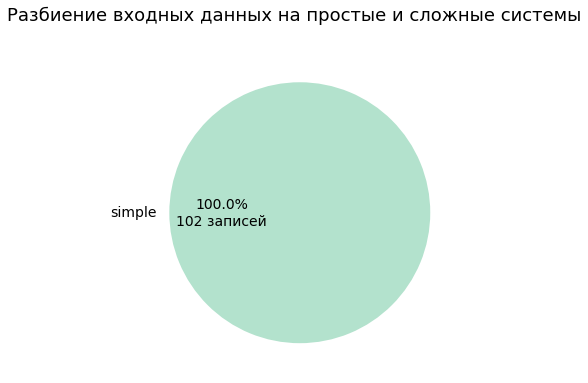

In [14]:
# Посмотрим на разбиение на простые и сложные модели
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(GEN_DF.complexity.value_counts(), colors=[LIGHT_CMAP(0), LIGHT_CMAP(0.7)],
       autopct=lambda pct: "{:.1f}%\n{:d} записей".format(pct, int(round(pct/100.*len(GEN_DF)))),
       labels=GEN_DF.complexity.unique(), textprops={'fontsize': 14})
fig.suptitle('Разбиение входных данных на простые и сложные системы', fontsize=18)
None

Посмотрим, что получилось. Для этого посмотрим на разброс параметров простых и сложных систем.

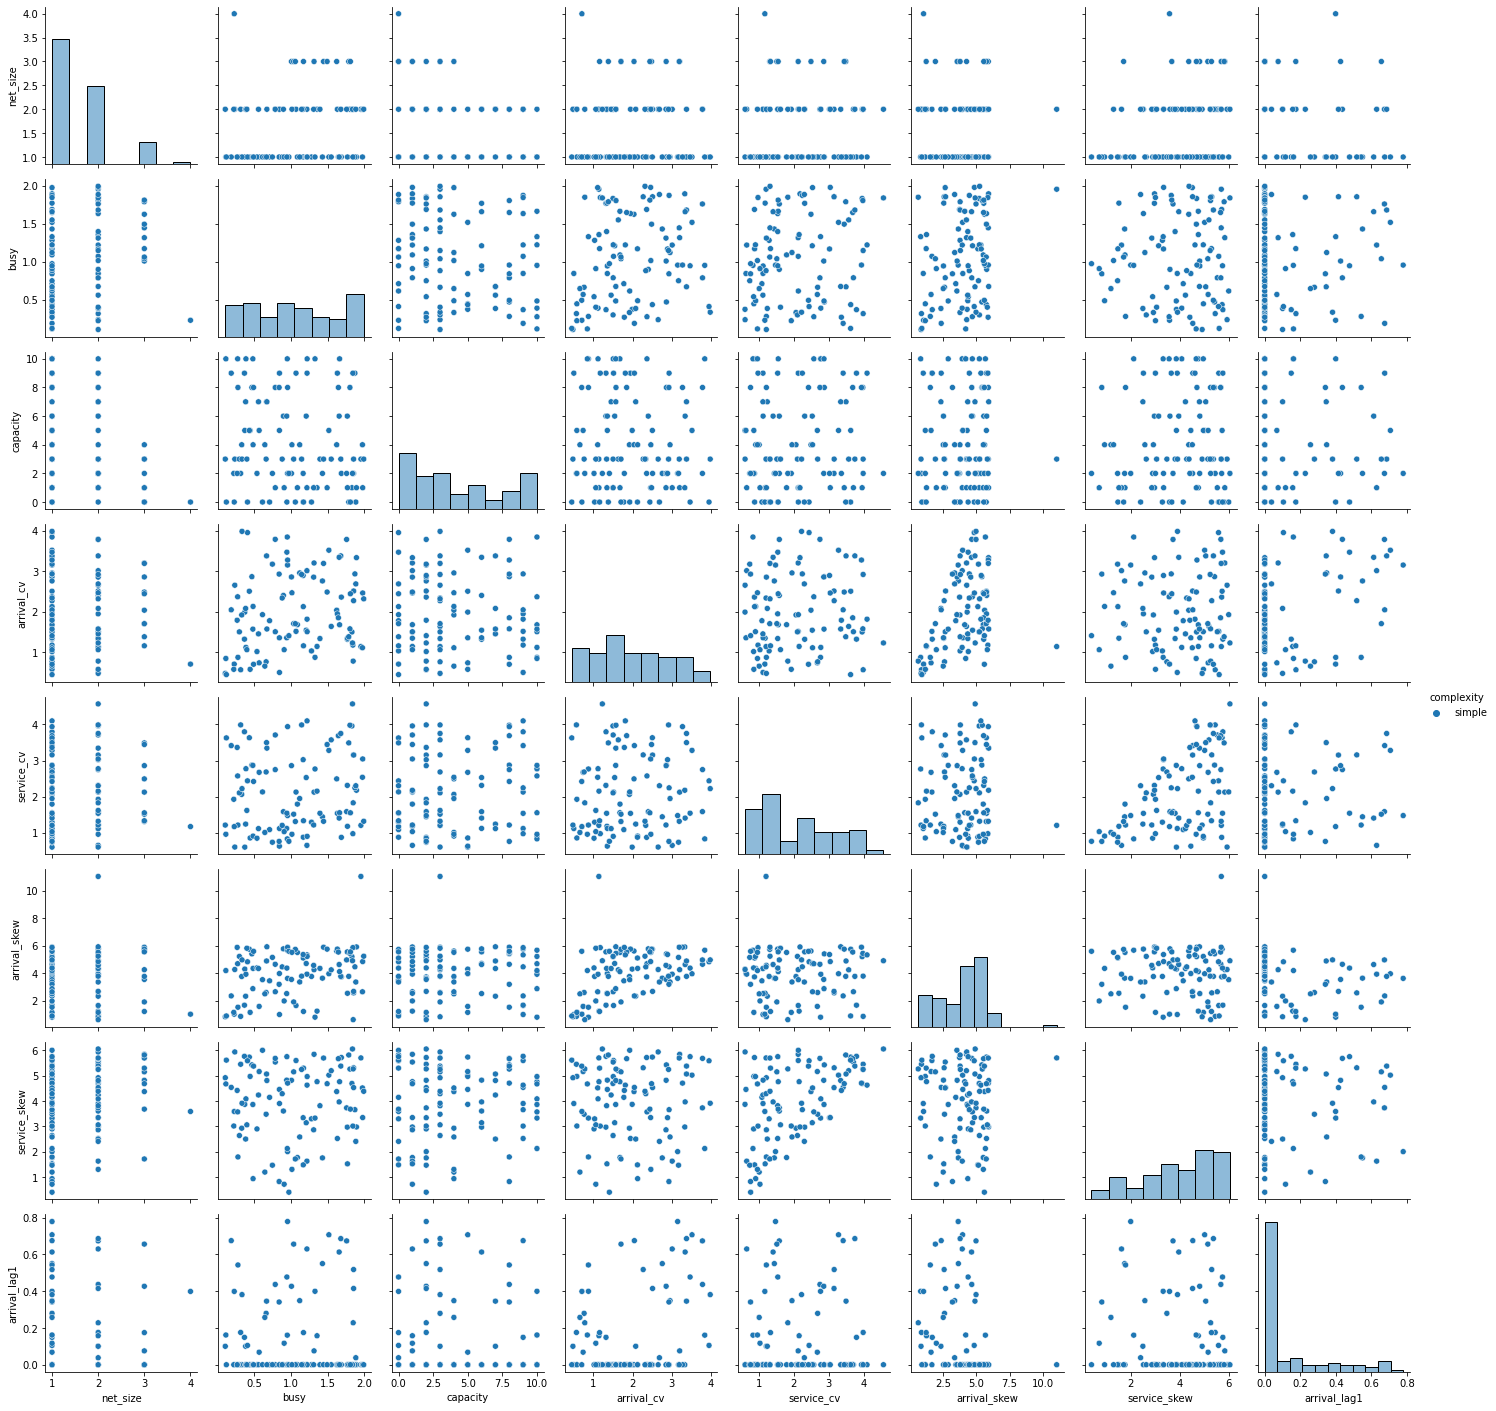

In [320]:
variables = ['net_size', 'busy', 'capacity', 'arrival_cv', 'service_cv', 'arrival_skew', 'service_skew', 'arrival_lag1']
g = sns.PairGrid(GEN_DF, hue='complexity', vars=variables)
g.map_diag(sns.histplot, fill=True)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [321]:
def _plot_input_scatter(df, axes, offset: float = 0.0, marker='o', color='black'):
    ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes
    
    scatter_kwargs = {
        'marker': marker,
        'alpha': 0.3,
        's': (df.capacity + 1)*20,
        'color': color,
    }
    
    ax1.scatter(df.net_size - 1 + offset, df.busy, **scatter_kwargs)
    ax2.scatter(df.net_size - 1 + offset, df.capacity, **scatter_kwargs)
    ax3.scatter(df.net_size - 1 + offset, df.arrival_cv, **scatter_kwargs)
    ax4.scatter(df.net_size - 1 + offset, df.service_cv, **scatter_kwargs)
    ax5.scatter(df.net_size - 1 + offset, df.arrival_skew, **scatter_kwargs)
    ax6.scatter(df.net_size - 1 + offset, df.service_skew, **scatter_kwargs)
    ax7.scatter(df.net_size - 1 + offset, df.arrival_lag1, **scatter_kwargs)
    
def plot_input_scatter(df):
    """
    Show scatter plots for inputs.
    """
    fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(24, 6), sharex=True,
                             gridspec_kw = {'height_ratios':[2,1]})
    
    color_simple = get_color(0, 'Dark2')
    color_complex = get_color(0.66, 'Dark2')
    
    _plot_input_scatter(df[df.complexity == 'simple'], axes[0], -0.2, marker='o', color=color_simple)
    _plot_input_scatter(df[df.complexity == 'complex'], axes[0], 0.2, marker='o', color=color_complex)
    
    columns = ['busy', 'capacity', 'arrival_cv', 'service_cv', 'arrival_skew', 
               'service_skew', 'arrival_lag1']
    
    for col, ax in zip(columns, axes[1]):
        sns.violinplot(data=df, x='net_size', y=col, hue='complexity', ax=ax, bw=.2,
                       inner="quartile", cut=True, split=True, palette={'complex': color_complex, 'simple': color_simple})
        ax.legend([], [], frameon=False)
    
    y_labels = [r'$\lambda / \mu$', 'Емкость', r'$c_a$', r'$c_s$', r'$\gamma_a$', r'$\gamma_s$', 'lag-1']
    
    for j, col_name in enumerate(columns):
        axes[0][j].set_title(col_name)
        axes[-1][j].set_xlabel('Размер сети', fontsize=14)

    for i, j in product(range(len(axes)), range(len(columns))):
        if i > 0:
            axes[i][j].grid()
        if i < len(axes) - 1:
            axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')
    
    fig.legend(handles=[
        Line2D([0], [0], color=color_simple, lw=4, label='Сети малого размера'),
        Line2D([0], [0], color=color_complex, lw=4, label='Сети большого размера'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#555', markersize=10, lw=4, label='Маленькая емкость очереди'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#555', markersize=20, lw=4, label='Большая емкость очереди'),
    ], bbox_to_anchor=(0.7, 0.0), fontsize=14, ncol=2)
    
    fig.suptitle("Разброс значений входных параметров", fontsize=16)

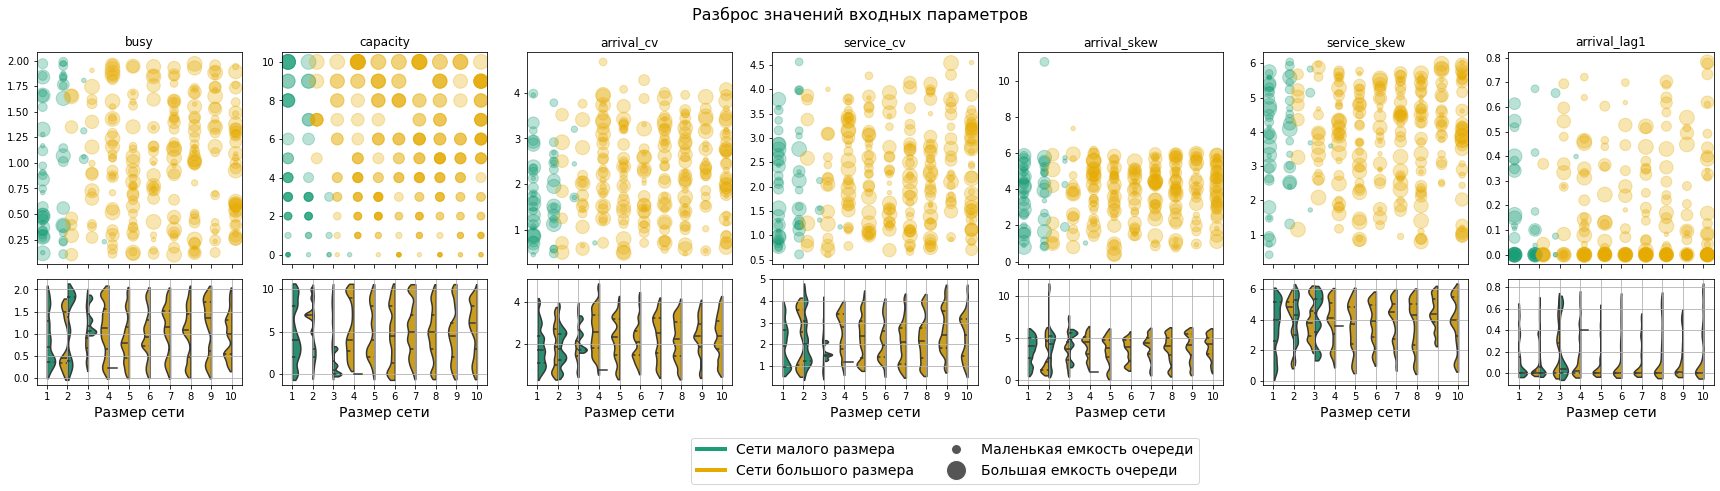

In [42]:
plot_input_scatter(GEN_DF.sample(300))
plt.tight_layout()
plt.show()

## Расчеты характеристик систем

Мы проведем несколько вариантов расчетов:

1. Точный расчет (только на тех сетях, на которых либо `small == True`, либо `intype == "basic"`)
2. Аппроксимацию выходящих потоков по трем моментам и коэффициенту автокорреляции с лагом 1
3. Аппроксимацию выходящих потоков по трем моментам без автокорреляции
4. Аппроксимацию выходящих потоков по первому моменту (то есть замену выходящих потоков Пуассоновским процессом)
5. Аппроксимацию и выходящих потоков, и входящего потока процессом Пуассона
6. Расчет с помощью метода Монте-Карло.

Заметим, что в случае (4) мы переходим от $MAP/PH/1/N$ на второй и последующих фазах к $M/PH/1/N$:
$$
\begin{aligned}
&MAP/PH/1/N \rightarrow MAP/PH/1/N \rightarrow \dots \rightarrow MAP/PH/1/N \Longrightarrow\\
&\qquad MAP/PH/1/N \rightarrow M/PH/1/N \rightarrow \dots \rightarrow M/PH/1/N
\end{aligned}
$$

А в случае (5) делаем еще более "смелую" замену:
$$
\begin{aligned}
&MAP/PH/1/N \rightarrow MAP/PH/1/N \rightarrow \dots \rightarrow MAP/PH/1/N \Longrightarrow\\
&\qquad M/PH/1/N \rightarrow M/PH/1/N \rightarrow \dots \rightarrow M/PH/1/N
\end{aligned}
$$

Для каждого метода мы будем анализировать три характеристики:

- среднюю межконцевую задержку (`delay`)
- среднюю вероятность доставки (`delivery_prob`)
- средний размер системы на последней фазе (`last_system_size`)
- сколько времени ушло на расчет (`elapsed`)

Для методов с аппроксимациями (2)-(5) также будем анализировать, насколько мы ошибаемся в оценке первых трех моментов и автокорреляции:

- максимальная ошибка в оценке среднего значения выходящего потока (`m1_err`)
- максимальная ошибка в оценке коэффициента вариации выходящего потока (`cv_err`)
- максимальная ошибка в оценке коэффициента асимметрии выходящего потока (`skew_err`)
- максимальная ошибка в оценке коэффициента автокорреляции с лагом 1 выходящего потока (`lag1_err`)

### Определение итерационной процедуры расчета

Все процедуры определены в модуле `pyqumo.algorithms.networks.mapph1n_tandem.py`. Нам понадобятся функция 
`solve_iteative()` и ее результат `SolveResults`. В следующих ячейках - их сигнатуры.

In [106]:
%pdef SolveResults

Class constructor information:
 SolveResults(
    skipped: bool,
    delay: Union[float, NoneType] = None,
    delivery_prob: Union[float, NoneType] = None,
    last_system_size: Union[float, NoneType] = None,
    elapsed: Union[float, NoneType] = None,
    max_inp_order: Union[int, NoneType] = None,
    max_out_order: Union[int, NoneType] = None,
    m1_err: Union[float, NoneType] = None,
    cv_err: Union[float, NoneType] = None,
    skew_err: Union[float, NoneType] = None,
    lag1_err: Union[float, NoneType] = None,
) -> None
 

In [108]:
%pdef solve_iterative

 solve_iterative(
    inp: Dict,
    reducer: Union[Callable[[pyqumo.arrivals.MarkovArrival], pyqumo.arrivals.MarkovArrival], NoneType] = None,
    reduce_arrival: bool = False,
    arrival: Union[pyqumo.arrivals.MarkovArrival, NoneType] = None,
    service: Union[pyqumo.random.PhaseType, NoneType] = None,
    capacity: Union[int, NoneType] = None,
    net_size: Union[int, NoneType] = None,
) -> pyqumo.algorithms.networks.mapph1n_tandem.SolveResults
 

Применять итерационную процедуру мы будем однотипно:

1. Выполняем процедуру с теми или иным аргументами `reducer` и `reduce_arrival`, результаты записываем в колонку `__solve_ret`
2. Растаскиваем результаты по отдельным колонками. У колонок будут названия с префиксами, зависящими от метода, и окончаниями такими же, как названия полей (например, `precise_delay`)
3. Удаляем служебную колонку `__solve_ret`

Названия префиксов будут:

1. `precise` - точный метод
2. `approx_map` - аппроксимация MAP-потоками (по 3 моментам и лагу)
3. `approx_ph3` - аппроксимация PH-распределениями (по 3 моментам)
4. `approx_ph1` - аппроксимация выходов потоками Пуассона
5. `approx_mm1` - аппроксимация потоками Пуассона всех входящих и выходящих процессов

> **!!! К сожалению, нельзя просто так взять, и применить алгоритм, особенно точный, к DataFrame-у из IPython (Jupyter) !!!**
>
> Если попытаться просто использовать `DataFrame.apply()`, то он не посчитает нужным освобождать память, и она, естественно, быстро кончится
(матрицы `4000x4000` к этому стимулируют).
>
> Возможное решение - использовать multiprocessing: выделяем по процессу на подсет, и применяем. А после завершения процесса его ресурсы вернутся к системе, независимо от воли garbage collector-а. 
> Но... **IPython не дает выполнять multiprocessing.Pool()**. Точнее, дает, но виснет.
>
> Единственное решение, которое я нашел - вынести расчет в отдельный скрипт, который вызывать через `%run`.
> Этот скрипт хранится в `experiments/bin/solve_mapph1n_tandem.py`.

In [169]:
def apply_iterative_solution(df: pd.DataFrame, prefix: str, reduce: bool = False, 
                             only_mean: bool = False, use_lag: bool = False, 
                             reduce_arrival: bool = False) -> pd.DataFrame:
    if not RUN_COMPUTE_GENERIC and f'{prefix}_delay' in df.columns:
        print("skipping, set FORCE_COMPUTE = True to enable.")
        return df
    
    reduce_ = 1 if reduce else 0
    only_mean_ = 1 if only_mean else 0
    use_lag_ = 1 if use_lag else 0
    reduce_arrival_ = 1 if reduce_arrival else 0
    
    %run bin/solve_mapph1n_tandem.py $GENERIC_DATA_CSV $prefix $reduce_ $only_mean_ $use_lag_ $reduce_arrival_
    return load_data(GENERIC_DATA_CSV)

### Точный расчет

Начнем с выполнения точного расчета.

In [170]:
df_ = load_data(GENERIC_DATA_CSV)
df_.columns

Index(['Unnamed: 0', 'net_size', 'capacity', 'complexity', 'arrival_mean',
       'arrival_rate', 'arrival_std', 'arrival_cv', 'arrival_skew',
       'arrival_lag1', 'service_mean', 'service_rate', 'service_std',
       'service_cv', 'service_skew', 'busy', '__ret', 'precise_skipped',
       'precise_delay', 'precise_delivery_prob', 'precise_last_system_size',
       'precise_elapsed', 'precise_max_inp_order', 'precise_max_out_order',
       'precise_m1_err', 'precise_cv_err', 'precise_skew_err',
       'precise_lag1_err', 'arrival', 'service'],
      dtype='object')

In [171]:
GEN_DF = apply_iterative_solution(GEN_DF, prefix='precise')

skipping, set FORCE_COMPUTE = True to enable.


In [172]:
def plot_solution_stats(df, prefix):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 6))
    
    col_delay = f'{prefix}_delay'
    col_delivery_prob = f'{prefix}_delivery_prob'
    col_system_size = f'{prefix}_last_system_size'
    col_elapsed = f'{prefix}_elapsed'
    col_inp_order = f'{prefix}_max_inp_order'
    col_out_order = f'{prefix}_max_out_order'
    
    sns.kdeplot(ax=axes[0][0], data=df, x=col_delay, fill=True)
    sns.kdeplot(ax=axes[0][1], data=df, x=col_delivery_prob, fill=True)
    sns.kdeplot(ax=axes[0][2], data=df, x=col_system_size, fill=True)
    sns.kdeplot(ax=axes[1][0], data=df, x=col_elapsed, fill=True)
    
#     sns.histplot(ax=axes[1][1], data=df, x=, fill=True, label="Max. inp. order", color=[CMAP(0)])
    sns.scatterplot(ax=axes[1][1], data=df, x=col_out_order, y=col_inp_order)
    
    g = sns.boxplot(ax=axes[1][2], x="variable", y="value",
                data=pd.melt(df[[
                    f'{prefix}_m1_err', f'{prefix}_cv_err',
                    f'{prefix}_skew_err', f'{prefix}_lag1_err'
                ]]), fliersize=0)
    g.set_xticklabels(['m1_err', 'cv_err', 'skew_err', 'lag1_err'], rotation=45)
    
    for ax_row in axes:
        for ax in ax_row:
            ax.grid()

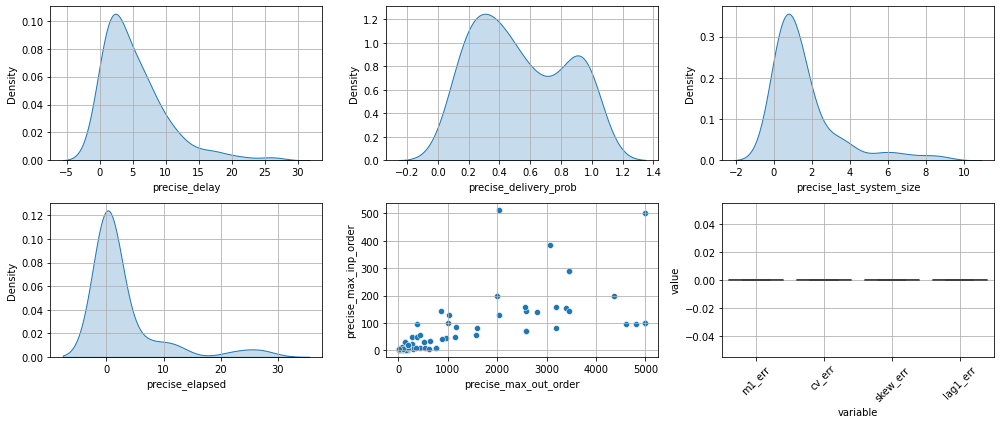

In [173]:
plot_solution_stats(GEN_DF[GEN_DF.precise_skipped == False], 'precise')
plt.tight_layout()
plt.show()

In [174]:
GEN_DF['precise_delivery_prob'].describe()

count    102.000000
mean       0.530954
std        0.292277
min        0.093326
25%        0.279570
50%        0.469649
75%        0.821925
max        1.000000
Name: precise_delivery_prob, dtype: float64

In [175]:
GEN_DF['precise_elapsed'].describe()

count    102.000000
mean       2.863173
std        6.416905
min        0.001349
25%        0.005422
50%        0.038114
75%        0.998973
max       27.889738
Name: precise_elapsed, dtype: float64

Мы будем рассматривать четыре варианта аппроксимаций:

- апрроксимацию по трем моментам и коэффициенту автокорреляции
- аппроксимацию по трем моментам и нулевой автокорреляции
- аппроксимацию по первому моменту ($M/PH/1/N$)
- замена всех входящих MAP экспоненциальными распределениями (включая первый узел)

### Замена всех MAP экспонентами

In [298]:
GEN_DF = apply_iterative_solution(
    GEN_DF, 
    prefix='approx_mm1',
    reduce=True, use_lag=False, only_mean=True,
    reduce_arrival=True,
)

skipping, set FORCE_COMPUTE = True to enable.


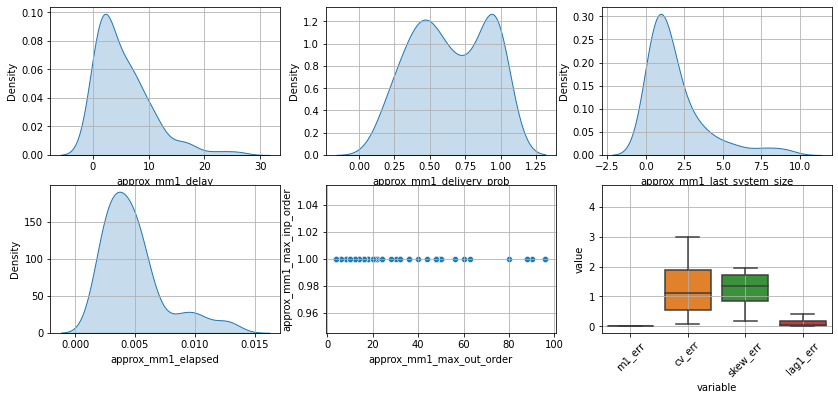

In [299]:
plot_solution_stats(GEN_DF[GEN_DF.precise_skipped == False], 'approx_mm1')

Теперь посмотрим на ошибку приближения.

In [327]:
def plot_approx_scatters_of(df, prefix, title="", base_prefix='precise', only_precise=True):
    metrics = ['delay', 'delivery_prob', 'last_system_size']
    if only_precise:
        df = df[df.precise_skipped == False]
    fig, axes = plt.subplots(figsize=(len(metrics) * 4, 4), nrows=1, ncols=len(metrics))
    for i, metric in enumerate(metrics):
        approx_col = f'{prefix}_{metric}'
        precise_col = f'{base_prefix}_{metric}'
        sns.scatterplot(ax=axes[i], data=df, x=precise_col, y=approx_col, size='net_size', hue='net_size')
    for ax in axes:
        ax.grid()
        max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([0, max_val], [0, max_val], linestyle='--')
    if title:
        fig.suptitle(title, fontsize=16)


def plot_approx_errors_of(df, prefix, title="", limit_y=False, base_prefix='precise', only_precise=True):
    if only_precise:
        df = df[df.precise_skipped == False]
    metrics = ['delay', 'delivery_prob', 'last_system_size']
    fig, axes = plt.subplots(figsize=(12, len(metrics) * 3), nrows=len(metrics), ncols=4, sharey=True)
    for i, metric in enumerate(metrics):
        err_col = f'{metric}_error'
        approx_col = f'{prefix}_{metric}'
        precise_col = f'{base_prefix}_{metric}'
        df[err_col] = abs((df[approx_col] - df[precise_col]) / df[precise_col])
        sns.boxplot(data=df, x='net_size', y=err_col, ax=axes[i][0])
        sns.scatterplot(data=df, x='arrival_cv', y=err_col, hue='net_size', ax=axes[i][1])
        sns.scatterplot(data=df, x='busy', y=err_col, hue='net_size', ax=axes[i][2], size="net_size")
        sns.scatterplot(data=df, x='arrival_lag1', y=err_col, hue='net_size', ax=axes[i][3], size="net_size")
    for ax_row in axes:
        for ax in ax_row:
            if limit_y:
                ax.set_ylim((0, 1))
            ax.grid()
    if title:
        fig.suptitle(title, fontsize=16)

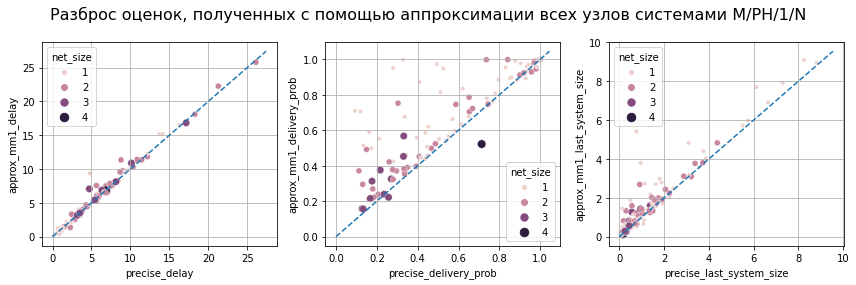

In [291]:
plot_approx_scatters_of(GEN_DF, 'approx_mm1', 
                        title="Разброс оценок, полученных с помощью аппроксимации всех узлов системами M/PH/1/N")
plt.tight_layout()

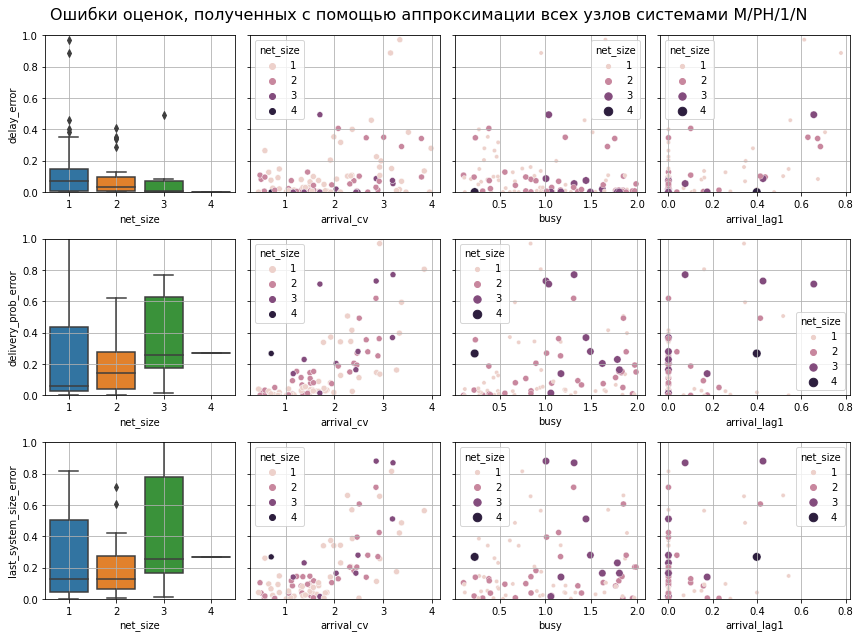

In [290]:
plot_approx_errors_of(GEN_DF, 'approx_mm1', limit_y=True, 
                      title="Ошибки оценок, полученных с помощью аппроксимации всех узлов системами M/PH/1/N")
plt.tight_layout()

#### Замена выходящих MAP экспонентами

In [261]:
GEN_DF = apply_iterative_solution(
    GEN_DF, 
    prefix='approx_ph1',
    reduce=True, use_lag=False, only_mean=True,
    reduce_arrival=False,
)

skipping, set FORCE_COMPUTE = True to enable.


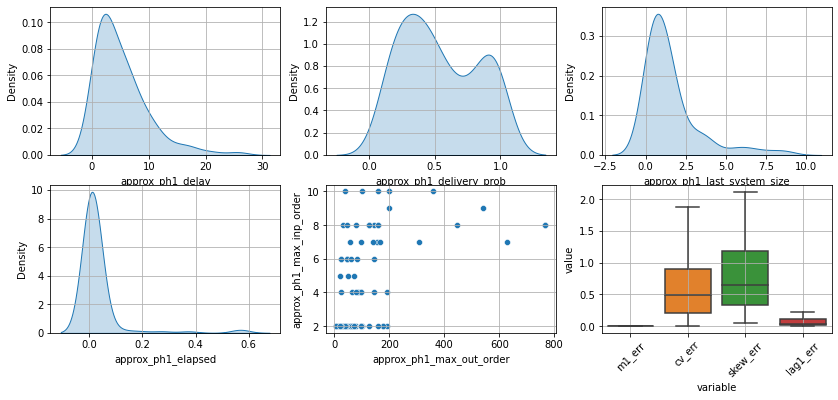

In [262]:
plot_solution_stats(GEN_DF[GEN_DF.precise_skipped == False], 'approx_ph1')

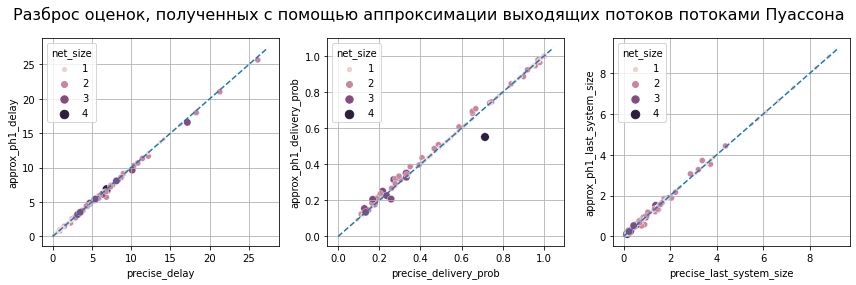

In [292]:
plot_approx_scatters_of(GEN_DF, 'approx_ph1',
                       title="Разброс оценок, полученных с помощью аппроксимации выходящих потоков потоками Пуассона")
plt.tight_layout()

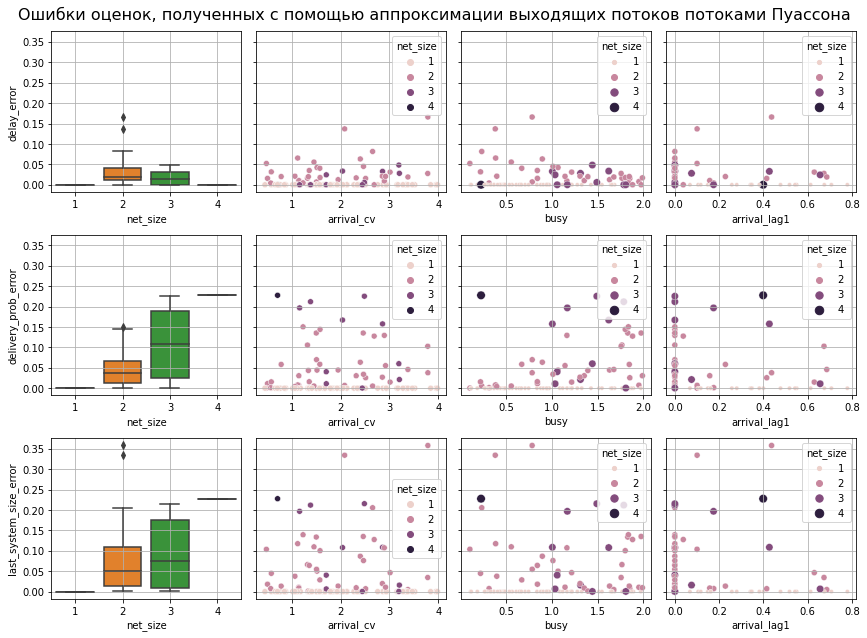

In [293]:
plot_approx_errors_of(GEN_DF, 'approx_ph1', title="Ошибки оценок, полученных с помощью аппроксимации выходящих потоков потоками Пуассона")
plt.tight_layout()

#### Замена выходящих MAP по трем моментам

In [183]:
GEN_DF = apply_iterative_solution(
    GEN_DF, 
    prefix='approx_ph3',
    reduce=True, use_lag=False, only_mean=False,
    reduce_arrival=False,
)

  0%|          | 0/25 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

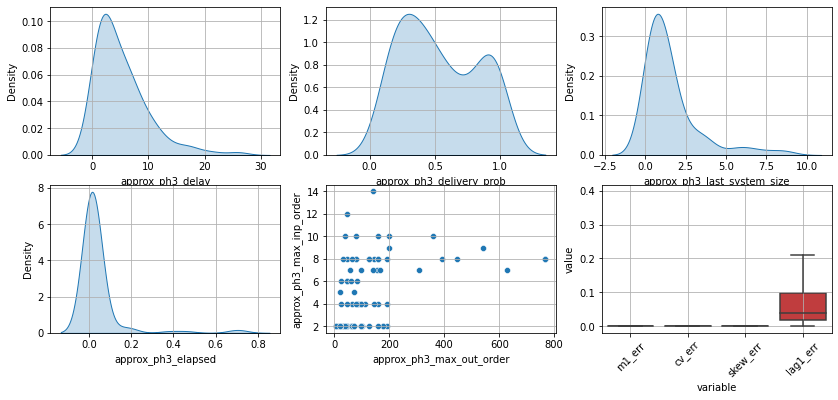

In [184]:
plot_solution_stats(GEN_DF[GEN_DF.precise_skipped == False], 'approx_ph3')

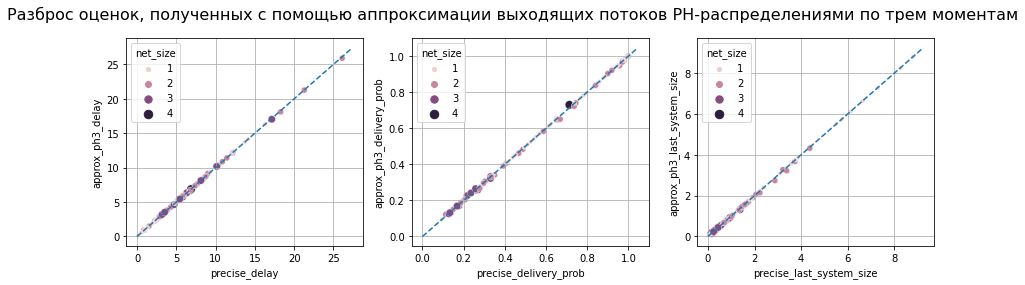

In [294]:
plot_approx_scatters_of(GEN_DF, 'approx_ph3', title="Разброс оценок, полученных с помощью аппроксимации выходящих потоков PH-распределениями по трем моментам")
plt.tight_layout()

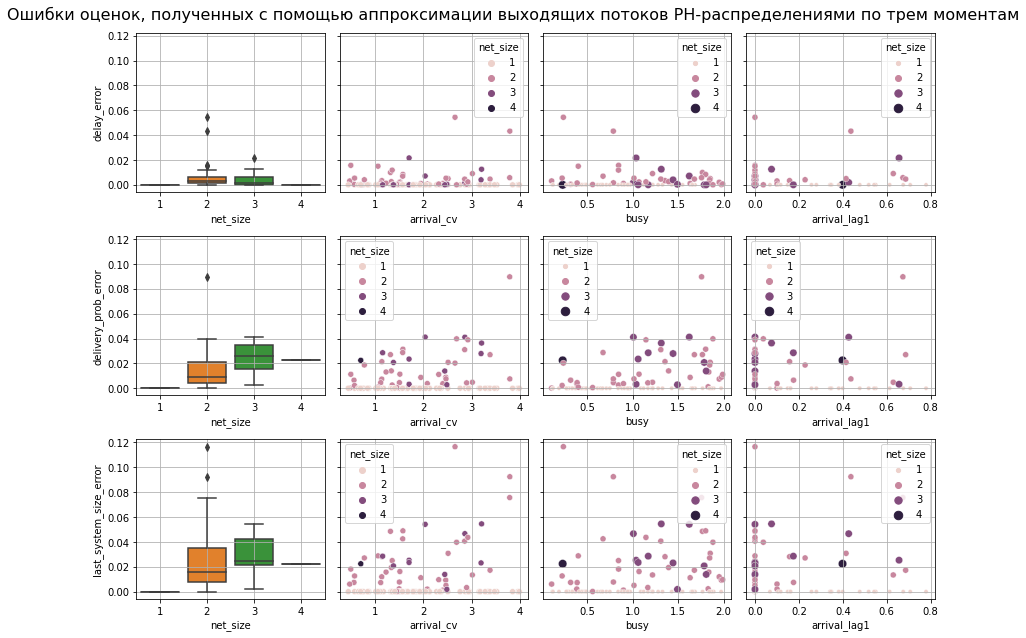

In [295]:
plot_approx_errors_of(GEN_DF, 'approx_ph3', title="Ошибки оценок, полученных с помощью аппроксимации выходящих потоков PH-распределениями по трем моментам")
plt.tight_layout()

#### Замена выходящих MAP по трем моментам и коэффициенту автокорреляции с лагом 1

In [190]:
GEN_DF = apply_iterative_solution(
    GEN_DF, 
    prefix='approx_map',
    reduce=True, use_lag=True, only_mean=False,
    reduce_arrival=False,
)

  0%|          | 0/25 [00:00<?, ?it/s]

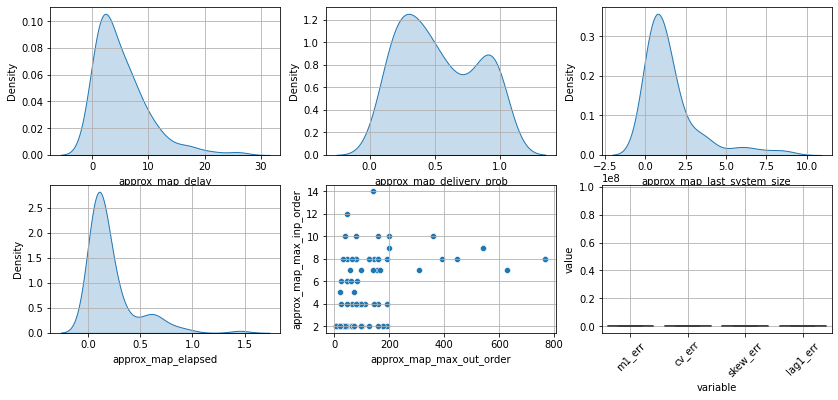

In [192]:
plot_solution_stats(GEN_DF[GEN_DF.precise_skipped == False], 'approx_map')

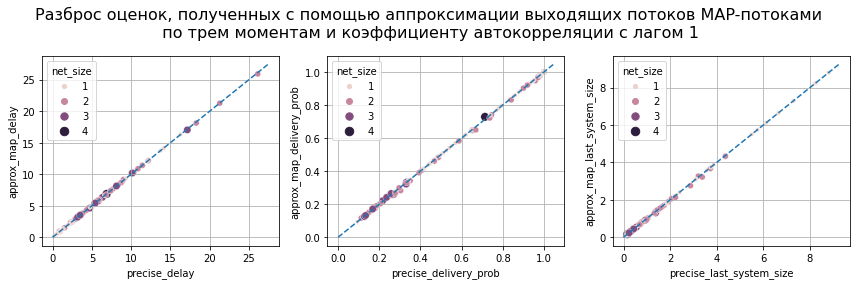

In [296]:
plot_approx_scatters_of(GEN_DF, 'approx_map', title="Разброс оценок, полученных с помощью аппроксимации выходящих потоков MAP-потоками\n по трем моментам и коэффициенту автокорреляции с лагом 1")
plt.tight_layout()

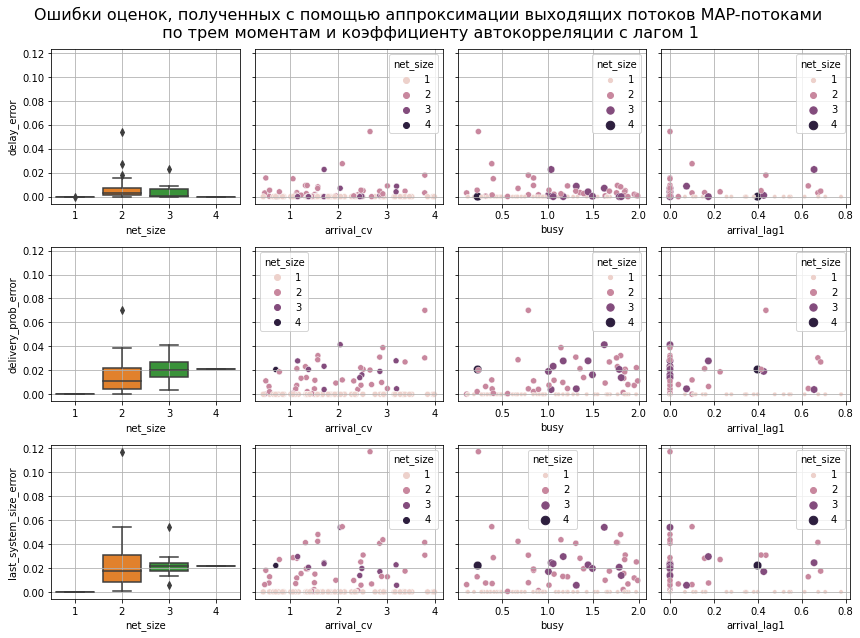

In [297]:
plot_approx_errors_of(GEN_DF, 'approx_map', title="Ошибки оценок, полученных с помощью аппроксимации выходящих потоков MAP-потоками\n по трем моментам и коэффициенту автокорреляции с лагом 1")
plt.tight_layout()

### Вычисление характеристик системы с помощью метода Монте-Карло

In [322]:
def apply_simulation(df):
#     if not RUN_COMPUTE_GENERIC and f'sim_delay' in df.columns:
#         print("skipping, set FORCE_COMPUTE = True to enable.")
#         return df
    
    %run bin/simulate_mapph1n_tandem.py $GENERIC_DATA_CSV $MAX_PACKETS $NUM_PROCESSORS
    return load_data(GENERIC_DATA_CSV)

In [323]:
GEN_DF = apply_simulation(GEN_DF)

  0%|          | 0/10 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

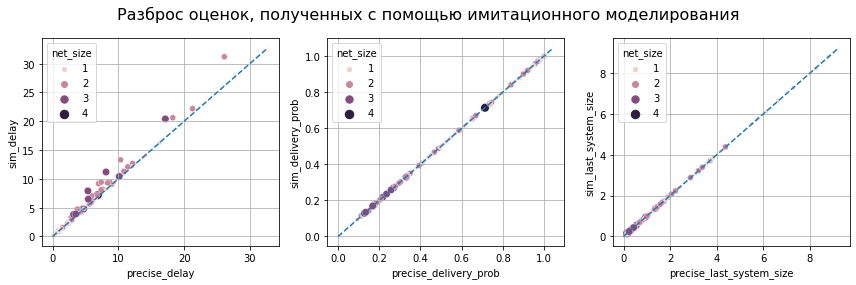

In [328]:
plot_approx_scatters_of(GEN_DF, 'sim', title="Разброс оценок, полученных с помощью имитационного моделирования")
plt.tight_layout()

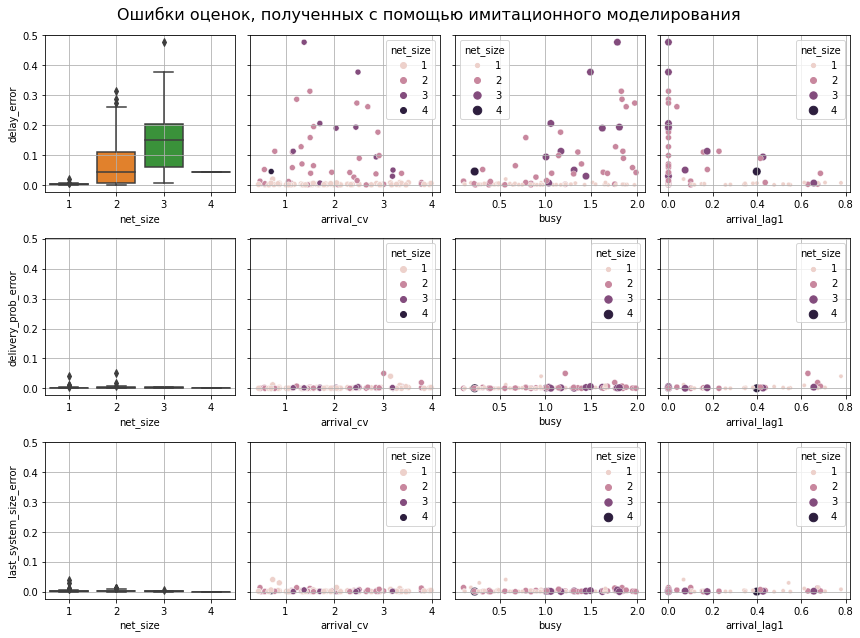

In [329]:
plot_approx_errors_of(GEN_DF, 'sim', title="Ошибки оценок, полученных с помощью имитационного моделирования")
plt.tight_layout()

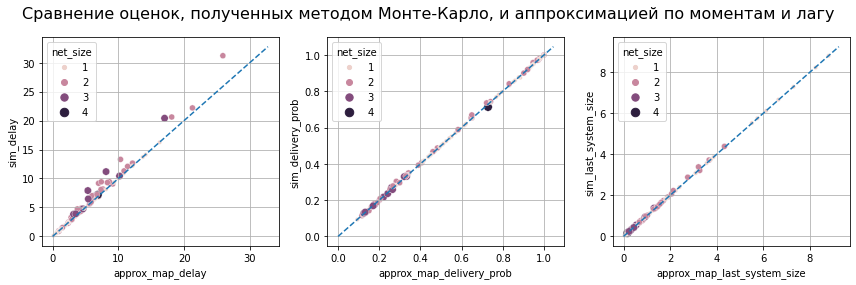

In [330]:
plot_approx_scatters_of(GEN_DF, 'sim', title="Сравнение оценок, полученных методом Монте-Карло, и аппроксимацией по моментам и лагу",
                        base_prefix='approx_map', only_precise=False)
plt.tight_layout()

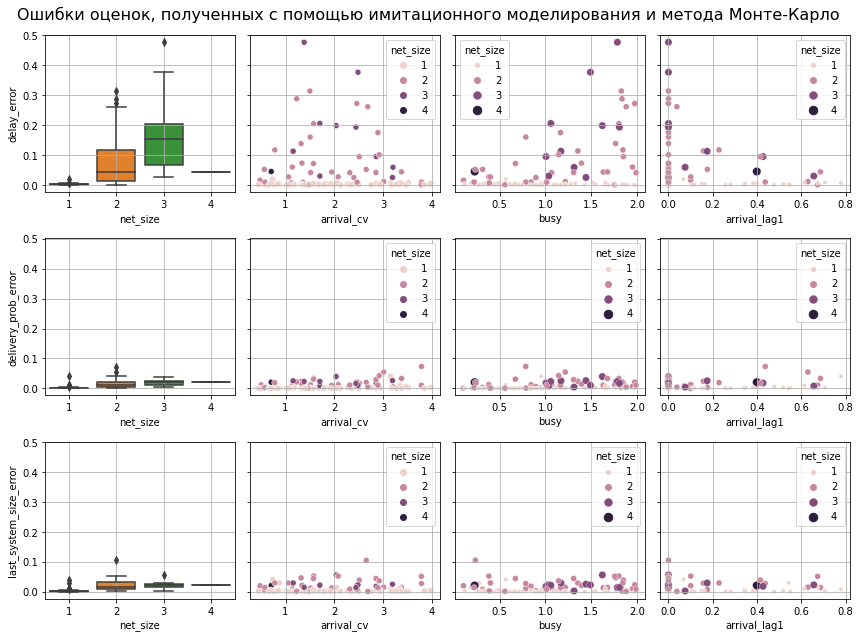

In [331]:
plot_approx_errors_of(GEN_DF, 'sim', title="Ошибки оценок, полученных с помощью имитационного моделирования и метода Монте-Карло",
                      base_prefix='approx_map', only_precise=False)
plt.tight_layout()

## Схождение метода Монте-Карло